# Experiment analysis

How people fake? For how long? How others succeed (or fail) to detect faked behaviour?

In [1]:
import collections
import datetime
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns

%matplotlib inline

In [2]:
DATA_DIR = 'data'
PLOTS_DIR = '../graphics'
SIGNIFICANCE = .05
SIGNIFICANCE_COLOR = '0.9'

In [3]:
def savefig(filename):
    filename = f'analysis_{filename}.svg'
    plt.savefig(os.path.join(PLOTS_DIR, filename))

## Basic demographics

In [4]:
def get_questionnaires_generator(data_dir):
    """
    Read all questionnaires data from disk.
    """
    for session_dir in os.listdir(data_dir):
        if not session_dir.startswith('session'):
            continue  # Skip the pilot dir
        session_path = os.path.join(data_dir, session_dir)
        session_number = int(session_dir[-1])
        for participant_dir in os.listdir(session_path):
            if not participant_dir.startswith('participant'):
                continue
            participant_id = int(participant_dir[len('participant'):])
            with open(os.path.join(data_dir, session_dir, participant_dir, 'questionnaires.json')) as f:
                yield {
                    'participant': participant_id,
                    'session': session_number,
                    **json.load(f)
                }

In [5]:
participants = pd.DataFrame(list(get_questionnaires_generator(DATA_DIR))).set_index('participant')
participants.groupby('gender').agg({'age': ['count', 'mean', 'std']})

age                     
       count       mean       std
gender                           
female     6  27.000000  2.529822
male       6  33.666667  9.709102

In [6]:
print(f'Age range {participants.age.min()} to {participants.age.max()}')

Age range 23 to 52


## Experiments events

Most of the experiment data comes from the server log file. Preprocessed, it looks like this:

``` 
15:48:12.254 [info] GET /1/participant-id/1
15:48:21.245 [info] GET /1/talking/start
15:48:21.267 [info] GET /1/talking/stop
15:49:03.221 [info] GET /1/autopilot/start
17:29:51.849 [info] POST /scores/reset-hard
17:57:35.544 [info] POST /scores/reset-scores
...
```

The code bellow prepare the data to work with convenient `DataFrames`.

In [7]:
def get_logs(data_dir):
    """
    Read all log files from disk.
    """
    logs = {}
    for session_dir in os.listdir(data_dir):
        if not session_dir.startswith('session'):
            continue  # Skip the pilot dir
        session_path = os.path.join(data_dir, session_dir)
        session_number = int(session_dir[-1])
        assert os.path.isdir(session_path), f'{session_path} is not a directory'
        with open(os.path.join(session_path, 'experiment.log')) as f:
            logs[session_number] = f.read().splitlines()
            
    return logs

In [8]:
class Event(collections.namedtuple('Event', ['session', 'timestamp', 'kind', 'data'])):

        __slots__ = ()
        
        def __str__(self):
            data_str = ' '.join(f'{key}={val}' for key, val in self.data.items())
            return f'{self.timestamp.time()} [{self.session}] {self.kind}: {data_str}'


def parse_player_event(url):
    player, *raw_event = url[1:].split('/')
    
    data = {'player': int(player)}
    
    kind = raw_event[0].replace('-', '_')
    
    if kind == 'participant_id':
        data['participant'] = int(raw_event[1])
    elif kind in ['talking', 'autopilot']:
        data['start'] = raw_event[1] == 'start'
    elif kind == 'accuse':
        data['accused_player'] = int(raw_event[1])
        data['correct'] = raw_event[2] == 'correct'
    elif kind == 'collect_token':
        pass  # Nothing to do here
    else:
        raise AssertionError(f"Event of kind {kind} was not expected")

    return kind, data


def parse_log_line(session, line):
    """
    Parse line to an Event.
    """
    timestamp, _, http_method, url = line.split()
    timestamp = datetime.datetime.strptime(timestamp, '%H:%M:%S.%f')

    if http_method == 'GET':
        kind, data = parse_player_event(url)
    elif http_method == 'POST':
        kind = 'reset_scores'
        data = {'hard': url.endswith('reset-hard')}
    else:
        raise AssertionError(f'{http_method} requests were not expected!')

    return Event(session, timestamp, kind, data)

In [9]:
def to_fractional_seconds(timedelta):
    return timedelta.seconds + timedelta.microseconds / 1_000_000

In [10]:
def add_participant_id(events):
    """
    Run through the events and add participant ID with latest data from events of kind `participant-id`.
    """
    player_id_to_participant_id = {}
    for event in events:
        if event.kind == 'participant_id':
            player_id_to_participant_id[event.data['player']] = event.data['participant']
        else:
            for prefix in ['', 'accused_']:
                player_key = prefix + 'player'
                participant_key = prefix + 'participant'
                if player_key in event.data:
                    event.data[participant_key] = player_id_to_participant_id[event.data[player_key]]

In [11]:
def add_time(events, kind):
    player_to_start = {}
    for event in events:
        if event.kind == kind:
            player_id = event.data['player']
            if event.data['start']:
                player_to_start[player_id] = event.timestamp
            else:
                delta = event.timestamp - player_to_start[player_id]
                event.data['time'] = to_fractional_seconds(delta)

In [12]:
def add_went_undetected(events):
    autopiloting_and_wasnt_detected = set()  # A set of player IDs
    for event in events:
        if event.kind == 'autopilot':
            if event.data['start']:
                autopiloting_and_wasnt_detected.add(event.data['player'])
            else:
                event.data['went_undetected'] = event.data['player'] in autopiloting_and_wasnt_detected
        elif event.kind == 'accuse' and event.data['correct']:
             if event.data['accused_player'] in autopiloting_and_wasnt_detected:
                    autopiloting_and_wasnt_detected.remove(event.data['accused_player'])

In [13]:
def trim_to_main_task(events):
    last_participant_join = None
    for event in events:
        if event.kind == 'participant_id':
            last_participant_join = event.timestamp
    return [event for event in events if event.timestamp > last_participant_join]

In [14]:
def add_session_length(events):
    first, *_, last = events
    length = last.timestamp - first.timestamp
    for event in events:
        event.data['session_length'] = to_fractional_seconds(length)

In [15]:
def process_logs_to_events(logs):
    all_events = []
    for session, log in logs.items():
        events = [parse_log_line(session, line) for line in log]
        add_participant_id(events)
        add_went_undetected(events)
        add_time(events, 'talking')
        add_time(events, 'autopilot')
        events = trim_to_main_task(events)
        add_session_length(events)
        all_events += events
    return all_events

In [16]:
logs = get_logs(DATA_DIR)
events = process_logs_to_events(logs)

# Events analysis

In [17]:
def to_dataframe(events, filter_=None):
    dicts = []
    for event in events:
        conditions = [
            filter_ is None,
            callable(filter_) and filter_(event),
            event.kind == filter_,
        ]
        if any(conditions):
            dicts.append({
                'timestamp': event.timestamp,
                'session': event.session,
                **event.data
            })
    return pd.DataFrame(dicts).set_index('timestamp')

### Session lengths

In [18]:
pd.to_timedelta(
    to_dataframe(events).groupby('session').session_length.first(),
    unit='s',
)

session
1   00:14:49.703000
2   00:11:28.667000
3   00:12:50.101000
4   00:10:41.366000
Name: session_length, dtype: timedelta64[ns]

### Accusations

In [19]:
accusations = to_dataframe(events, 'accuse')

In [20]:
print(f'Ratio of correct accusations: {accusations.correct.mean():.3f}')

Ratio of correct accusations: 0.285


### Faking

In [21]:
faking = to_dataframe(events, filter_=lambda e: e.kind == 'autopilot' and not e.data['start'])

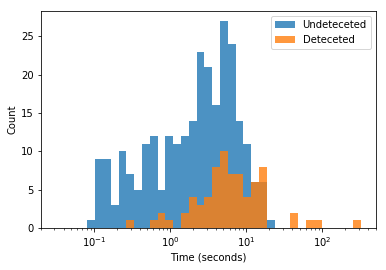

In [22]:
ax = plt.subplot()
kwargs = {'bins': np.logspace(-1.5, 2.5, 40), 'alpha': .8}
ax.hist(faking.time[faking.went_undetected == True], label='Undeteceted', **kwargs)
ax.hist(faking.time[faking.went_undetected == False], label='Deteceted', **kwargs)
ax.set_xscale('log')
plt.xlabel('Time (seconds)')
plt.ylabel('Count')
plt.legend()
savefig('hist_time_faking')

In [23]:
undetected = faking[faking.went_undetected == True].time
detected = faking[faking.went_undetected == False].time
t, p = sps.ttest_ind(undetected, detected)
p = p / 2  # Fixing p value for one sided t-test
degrees_of_freedom = len(undetected) + len(detected) - 2
print(f'Longer faking periods are easier to detect (t({degrees_of_freedom}) = {t:.3f}, p = {p:.3f})')

Longer faking periods are easier to detect (t(341) = -4.826, p = 0.000)


In [24]:
print(f'Ratio of undetected faking behaviours: {faking.went_undetected.mean():.3f}')

Ratio of undetected faking behaviours: 0.787


Compare the ratio of correct accusations (calculated above) to the ratio of time faking to see if accusation is generally above chance level. Assume choosing a random participant to accuse.

In [25]:
(faking.time / faking.session_length).sum() / 12

0.22030056080082747

Suggests that accusations are above chance level (accusing random participant in random timing).

### Per participant checks

To see if participant 9 / participant 13 (that are the same person) looks normal.

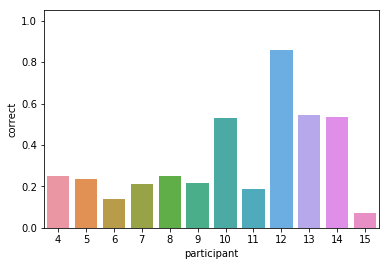

In [26]:
sns.barplot(x='participant', y='correct', errwidth=0, data=accusations);

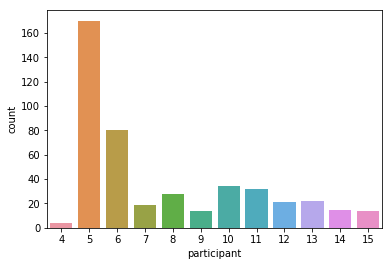

In [27]:
sns.countplot(x='participant', data=accusations);

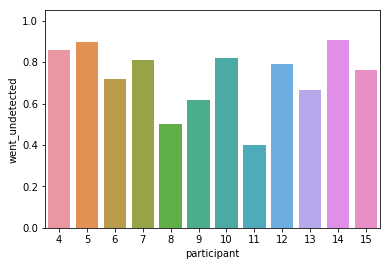

In [28]:
sns.barplot(x='participant', y='went_undetected', errwidth=0, data=faking);

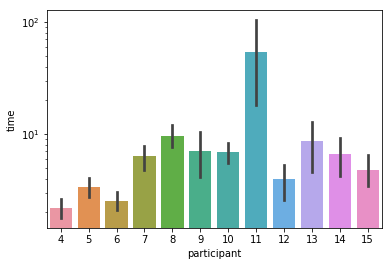

In [29]:
ax = sns.barplot(x='participant', y='time', data=faking);
ax.set_yscale('log')

## Participants stats

Compare how much players talk to how much they fake. Does faking affect their performance in the conversation? Other pairwise relationships in the participants stats? Gender vs. everything else?

Talking: ratio of talking portions (vs. silence from session length)

In [30]:
talking = to_dataframe(events, filter_=lambda e: e.kind == 'talking' and not e.data['start'])
aggregations = {'time': 'sum', 'session_length': 'first'}
participants_talking = talking.groupby(by='participant').agg(aggregations)

# Add the data to the participants (the questionnaires) dataframe.
participants['talking_ratio'] = participants_talking.time / participants_talking.session_length

Accusations: correct and per second

In [31]:
aggregations = {'correct': 'mean', 'session_length': 'first', 'session': 'count'}
participants_accusations = accusations.groupby(by='participant').agg(aggregations).rename(columns={'session': 'count'})

participants['accusations_per_sec'] = participants_accusations['count'] / participants_accusations['session_length']
participants['accusations_correct'] = participants_accusations['correct']

Faking: went undetected, time, and ratio (from session length)

In [32]:
aggregations = {'went_undetected': 'mean', 'time': ['mean', 'sum'], 'session_length': 'first'}
participants_faking = faking.groupby(by='participant').agg(aggregations)

participants['faking_went_undetected'] = participants_faking['went_undetected']
participants['faking_time'] = participants_faking.time['mean']
participants['faking_ratio'] = participants_faking.time['sum'] / participants_faking.session_length['first']

In [33]:
def corrfunc(x, y, **kws):
    (r, p) = sps.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p), xy=(.1, .8), xycoords=ax.transAxes)
    
    if p < SIGNIFICANCE:
        ax.set_facecolor(SIGNIFICANCE_COLOR)

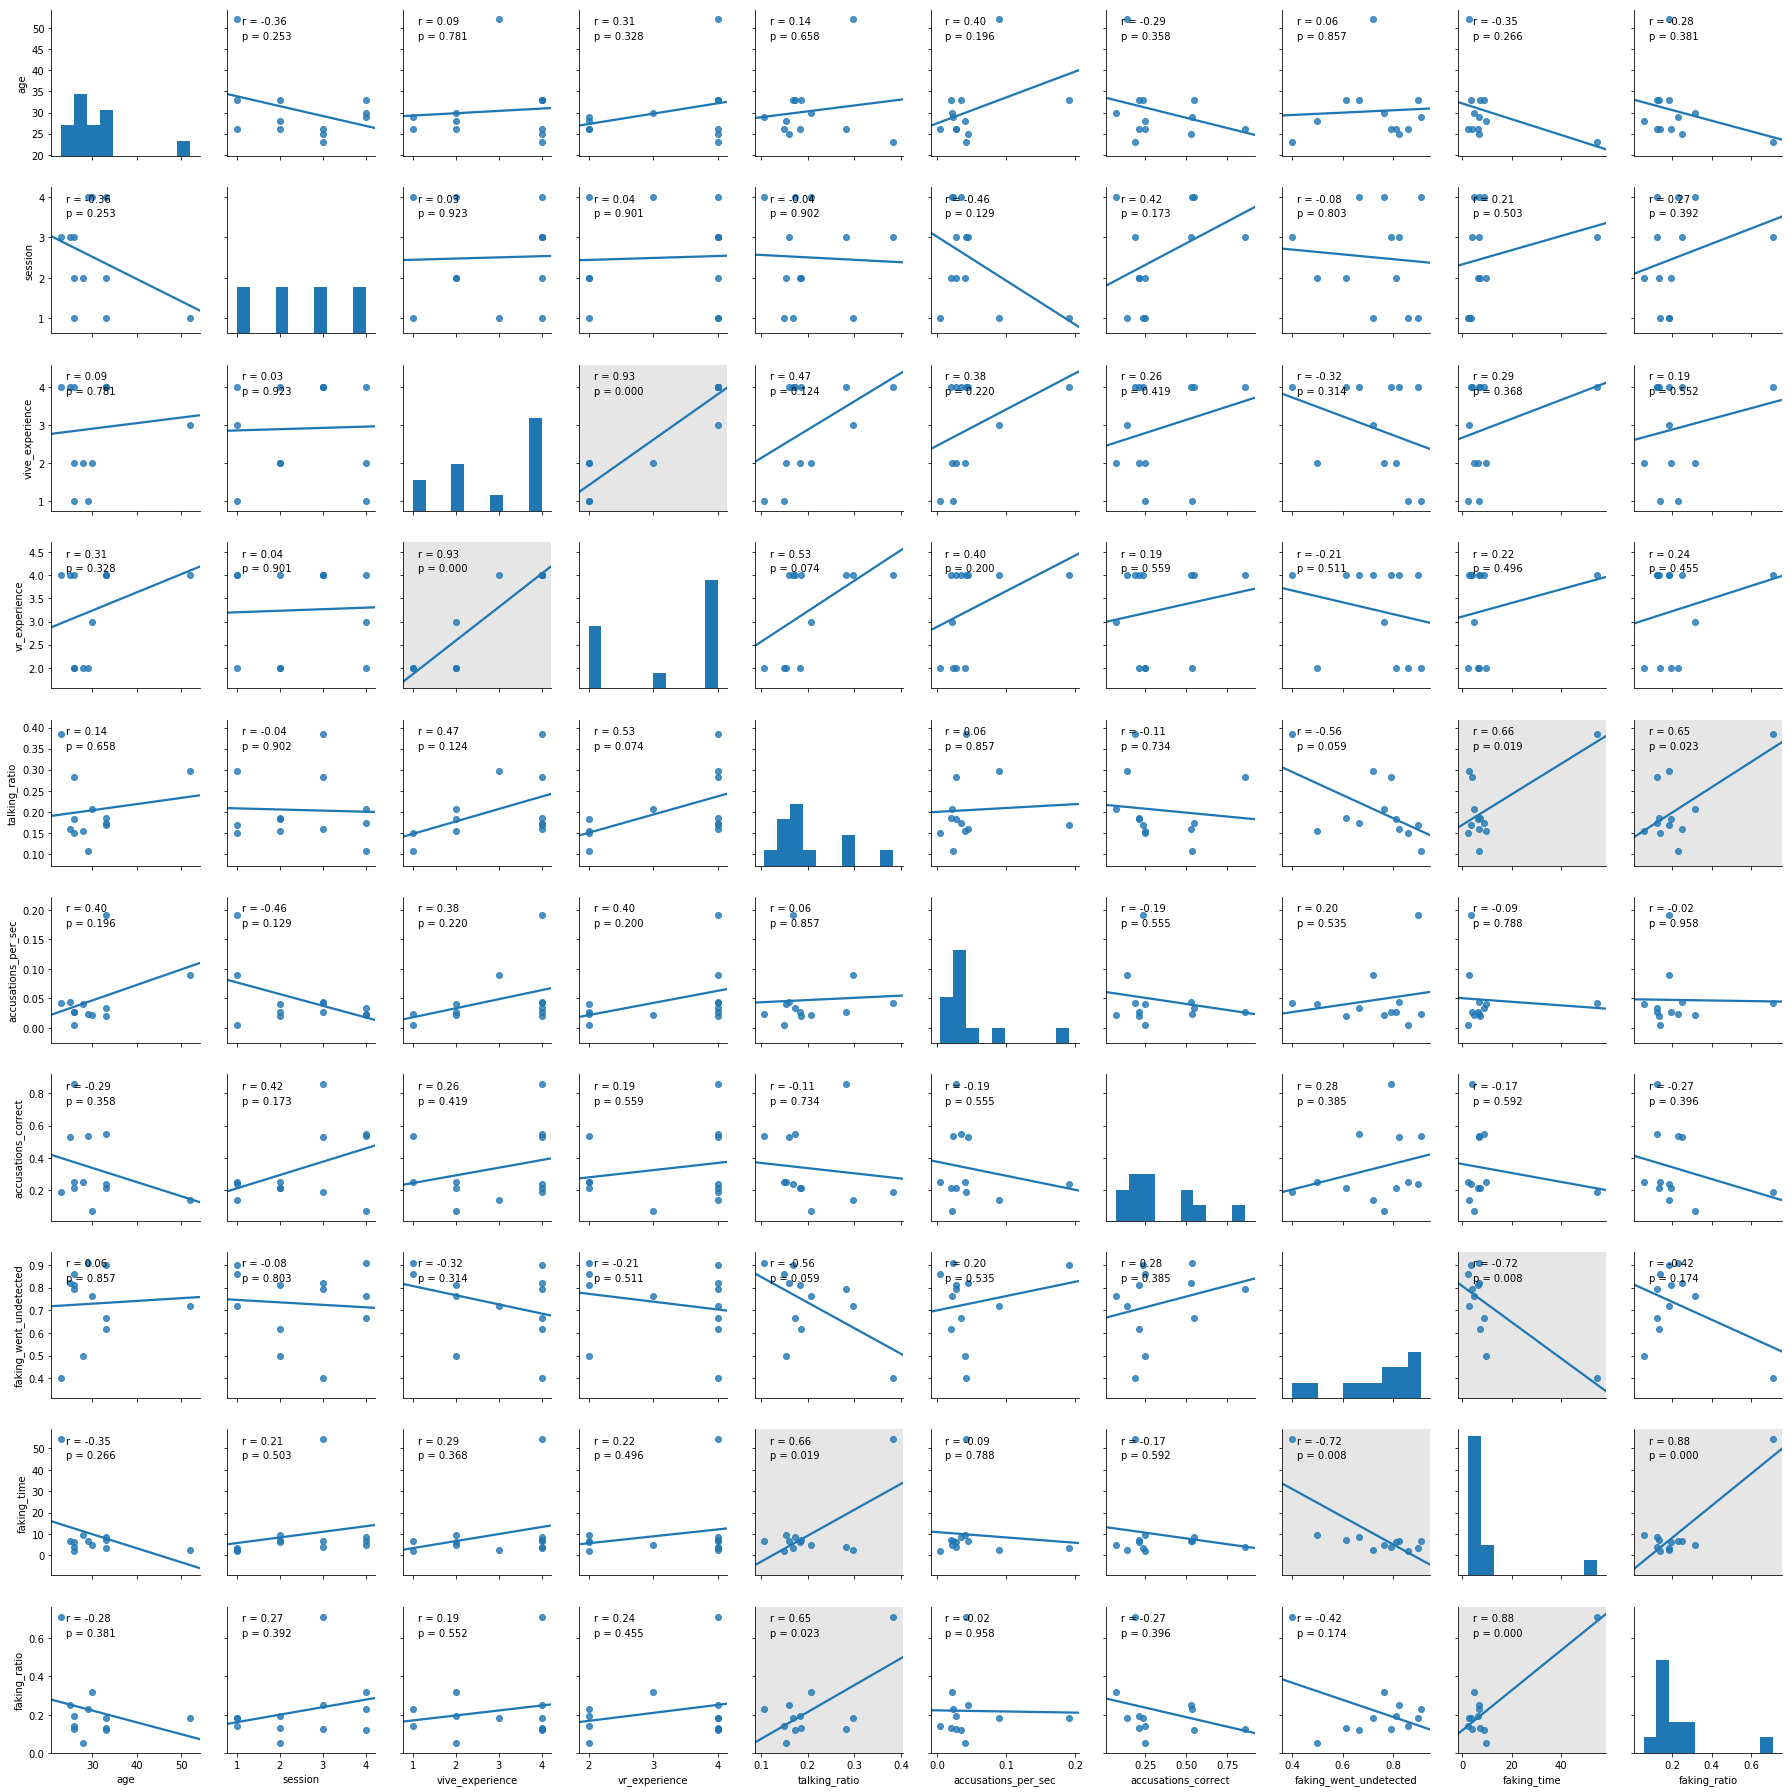

In [34]:
g = sns.pairplot(participants, kind='reg', plot_kws={'ci': None})
g.map_offdiag(corrfunc)
plt.tight_layout()

### Talking vs. faking

Found correlation between talking ratio (time out of session length) with faking ratio and average faking time. However, these are primarily caused by an outlier. These results are non-significant if the outlier is discarded. To motivate the removal of this outlier let's look at the participant faking strategy.

In [35]:
participant = participants.loc[11]
print('Faking strategy')
print('---------------')
print(participant.faking_strategy)

Faking strategy
---------------
FAKE IT TILL YOU MAKE IT. I was FAKING 50% of experience, idea was to keep on talking load of things to make people engage while I do my thing. I was also getting more personal in my speech so people can believe that I'm there with them


In [36]:
def report_p_value(p_value):
    limits = [.001, .01, .05]
    for limit in limits:
        if p_value < limit:
            return f'p < {limit}'
    return f'p > {max(limits)}'


def plot_regression_line(ax, x, y, **kwargs):
    fit_fn = np.poly1d(np.polyfit(x, y, 1))
    ax.plot(ax.get_xlim(), fit_fn(ax.get_xlim()), '--', **kwargs)

    
def regplot_with_and_without_outlier(data, xcol, ycol, stats_pos=(.03, .88), ax_args=None):
    
    def common_regplot(ax, x, y):
        (r, p) = sps.pearsonr(x, y)
        plot_regression_line(ax, x, y)
        ax.annotate(f'r = {r:.2f}\n{report_p_value(p)}', xy=stats_pos, xycoords=ax.transAxes)
        
        for field, args in ax_args.items():
            getattr(ax, 'set_' + field)(args)
            
    ax_args = {
        'xlabel': xcol.replace('_', ' ').capitalize(),
        'ylabel': ycol.replace('_', ' ').capitalize(),
        **(ax_args or {}),
    }

    data = data.copy()
    data['outlier'] = (np.abs(sps.zscore(data[[xcol, ycol]])) > 3).any(axis=1)
    
    x = data[xcol]
    y = data[ycol]
    x_normal = x[data.outlier == False]
    y_normal = y[data.outlier == False]
    x_outlier = x[data.outlier == True]
    y_outlier = y[data.outlier == True]
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

    ax1.scatter(x=x_normal, y=y_normal, label=None)
    ax1.scatter(x=x_outlier, y=y_outlier, label='outlier')
    common_regplot(ax1, x=x, y=y)
    ax1.legend(loc='lower right')
    
    ax2.scatter(x=x_normal, y=y_normal)
    ax_args.pop('ylabel')
    common_regplot(ax2, x=x_normal, y=y_normal)

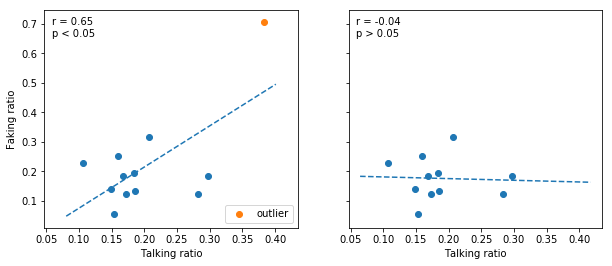

In [37]:
regplot_with_and_without_outlier(participants, 'talking_ratio', 'faking_ratio')
savefig('correlation_talking_ratio_vs_faking_ratio')

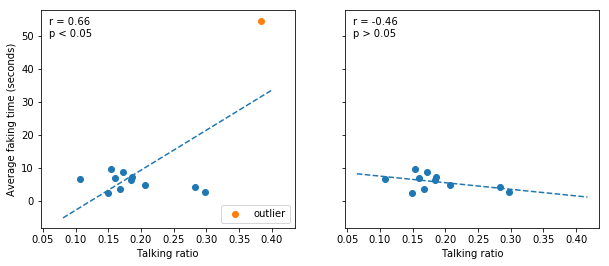

In [38]:
ax_args = {'ylabel': 'Average faking time (seconds)'}
regplot_with_and_without_outlier(participants, 'talking_ratio', 'faking_time', ax_args=ax_args)
savefig('correlation_talking_ratio_vs_faking_time')

### Average faking time vs. being undetectable

Similarly to the previous comparison (talking ratio vs. faking), this one is also affected by the same outlier. However, when the outlier is removed the general trend remain the same. Therefore, I will assume that there is a significant negative correlation between the avarage time a person is faking and the percentage of the participant undetected faking.

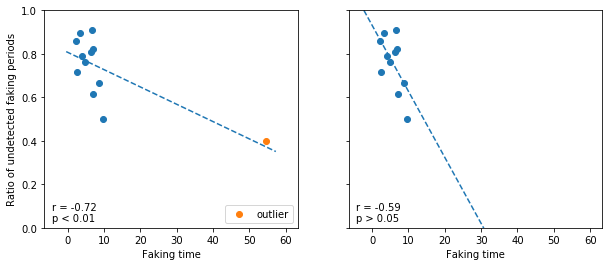

In [39]:
ax_args = {'ylim': (0, 1), 'ylabel': 'Ratio of undetected faking periods'}
regplot_with_and_without_outlier(participants, 'faking_time', 'faking_went_undetected',
                                 stats_pos=(.03, .03), ax_args=ax_args)
savefig('correlation_faking_time_vs_faking_undetected')

### Gender

In [40]:
def numerical_columns(df):
    for name, dtype in zip(df.columns, df.dtypes):
        if dtype in [np.int, np.float]:
            yield name

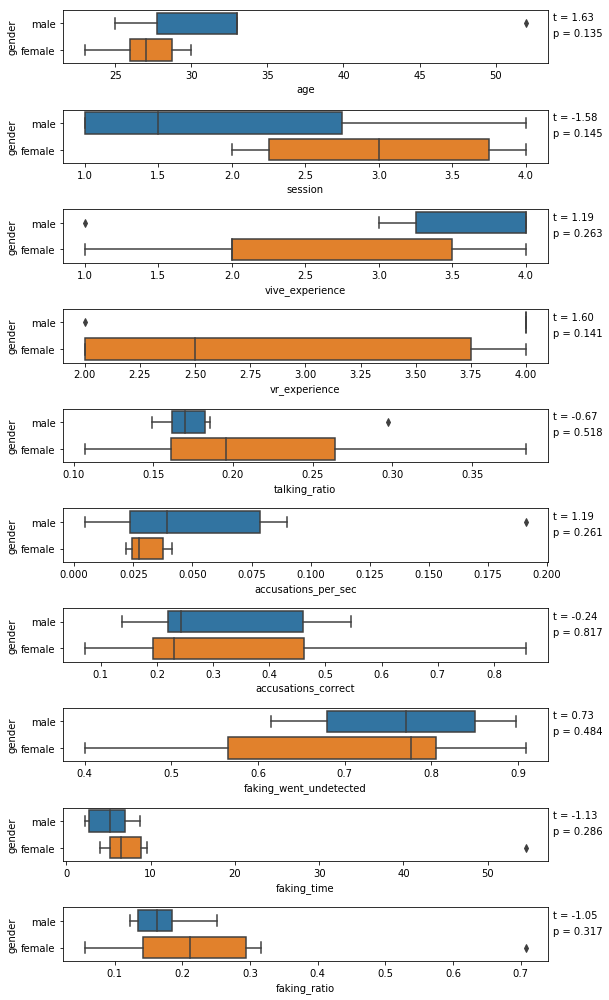

In [41]:
args = list(numerical_columns(participants))

_, axes = plt.subplots(nrows=len(args), ncols=1, figsize=(8, 14))

for arg, ax in zip(args, axes):
    
    (t, p) = sps.ttest_ind(
        participants[arg][participants.gender == 'male'],
        participants[arg][participants.gender == 'female'],
    )
    ax.annotate("t = {:.2f}".format(t), xy=(1.01, .8), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p), xy=(1.01, .5), xycoords=ax.transAxes)
    
    sns.boxplot(x=arg, y='gender', ax=ax, data=participants)

    if p < SIGNIFICANCE:
        ax.set_facecolor(SIGNIFICANCE_COLOR)
    
plt.tight_layout()

## Familiarity effects

Is it easier to detect when someone familiar is faking? Is the detection faster? Who are accused more, familiar or unfamiliar participants?

Familiarity vs. correct

In [42]:
def get_familiarity(participants, participant, coparticipant):
    """
    Get the participants DataFrame and return the familiairity
    between two participants (directed).
    """
    row = participants.loc[participant]
    for potential_coparticipant, rating in row.familiarity:
        if potential_coparticipant == coparticipant:
            return rating
    raise ValueError(f'No familiarity value between participant {participant} and {coparticipant}')

In [43]:
accusations['familiarity'] = accusations.apply(
    lambda x: get_familiarity(participants, x.participant, x.accused_participant),
    axis=1,
)

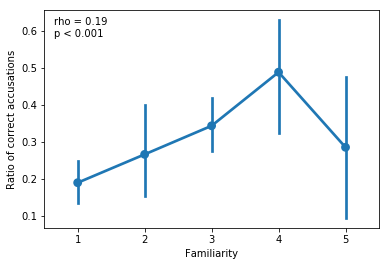

In [44]:
rho, p = sps.spearmanr(accusations.familiarity, accusations.correct)
ax = sns.pointplot(x='familiarity', y='correct', data=accusations)
ax.annotate(f'rho = {rho:.2f}\n{report_p_value(p)}', xy=(.03, .88), xycoords=ax.transAxes)
ax.set_xlabel('Familiarity')
ax.set_ylabel('Ratio of correct accusations')
savefig('pointplot_familiarity_vs_correct')

## Anecdots

In [45]:
def answers(participants, id_, fields):
    
    if isinstance(fields, str) or not isinstance(fields, collections.Iterable):
        fields = [fields]

    msg = []

    for field in fields:
        msg.append(field.replace('_', ' ').capitalize())
        msg.append('-' * len(field))
        msg.append(participants.loc[id_, field])
        msg.append('')

    title = f'Participant {id_}'
    header = '=' * len(title)

    return '{}\n{}\n\n{}'.format(title, header, '\n'.join(msg))

### Participant 7: noticing differences between participants

Participant 7 claims that it was easier to detect one of the participants. See how many correct / incorrect accusation this participant did, and how they are compared to the faking behaviours of these participants.

In [46]:
print(answers(participants, 7, ['comments', 'detecting_strategy']))

Participant 7

Comments
--------
for some reason it was quite obious for me when participant 9 fake it. however not so much when participant 8 did. It was amazing!! thank you!!

Detecting strategy
------------------
It wasn't as strategy to be honest I just could tell because the body language changed quite dramatically



In [47]:
(accusations[accusations.participant == 7]
 .groupby(['accused_participant', 'correct'])
 .session
 .count()
 .rename(columns={'session': 'count'})
)

accused_participant  correct
8                    False       5
9                    False      10
                     True        4
dtype: int64

In [48]:
accusations[accusations.participant == 7].groupby('accused_participant').correct.mean()

accused_participant
8    0.000000
9    0.285714
Name: correct, dtype: float64

In [49]:
participants[participants.session == participants.loc[7, 'session']].faking_ratio

participant
7    0.193843
8    0.055647
9    0.132685
Name: faking_ratio, dtype: float64

It seems that the participant claim is a result of the one of the other participants faking much more than the other. Overall, the participant got a very similar accusation performance to the avarage.

### Participants 12 and 14: detecting repetetive movement

Participant 12 got the highest accusation performanec (ratio of correct accusations). The participant reported strategy shows a partially understanding of how the system works - by repeating recorded movement of the players. This kind of understanding is also presented by participant 14.

In [50]:
print(answers(participants, 12, ['faking_strategy', 'detecting_strategy']))
print(answers(participants, 14, 'detecting_strategy'))

Participant 12

Faking strategy
---------------
Look for repetetive movement + create repetetive movement for myself. Click a lot when people look like they are faking

Detecting strategy
------------------
Look when they weren't making novel gestures. Look for repetition

Participant 14

Detecting strategy
------------------
Watching for repetitive behaviours or behaviour that looked a ______ robotic. Being more aware when someone was not speaking



In [51]:
participants.loc[[12, 14], 'accusations_correct']

participant
12    0.857143
14    0.533333
Name: accusations_correct, dtype: float64

In [52]:
participants['accusations_correct_z'] = sps.zscore(participants.accusations_correct)
participants['accusations_correct_cdf'] = sps.norm.cdf(participants.accusations_correct_z)
participants[['accusations_correct_z', 'accusations_correct_cdf']]

,accusations_correct_z,accusations_correct_cdf
participant,,
6,-0.900032,0.184052
5,-0.454725,0.324654
4,-0.387761,0.349096
7,-0.567505,0.285185
8,-0.387761,0.349096
9,-0.550387,0.291027
11,-0.672356,0.250679
12,2.376874,0.991270
10,0.884545,0.811799


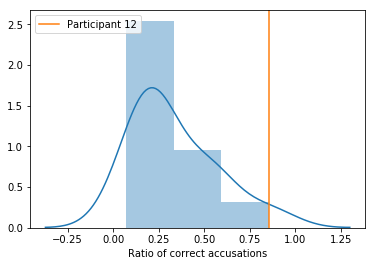

In [53]:
ax = sns.distplot(participants.accusations_correct)
x = participants.loc[12, 'accusations_correct']
ax.plot([x, x], [0, 100], label=f'Participant 12')
ax.set_xlabel('Ratio of correct accusations')
plt.legend(loc='upper left')
savefig('participant12_accusations_correct')

Assuming a normal distribution of accusation performance, the probability to get participant 12 score is far right on the distribution tail. Thus, suggesting that "cracking" the system behaviour helps in performance. Participant 14, however, doesn't present a distinctive performance.

### Participant 5 and 8: detecting automated head nods

These participants claimed that the head nods were a good indication. That's indeed part of how the system operates. Due to misunderstanding, participant 5 accused others in very high frequency that probably lowered the performance. On the surface, the participant performance is low, so it's hard to tell what was the effect of this understanding. Participant 8 performance is not high either, suggesting that maybe they didn't really manage to use head nods as an indication.

In [54]:
print(answers(participants, 5, ['faking_strategy', 'comments']))
print(answers(participants, 8, 'detecting_strategy'))

Participant 5

Faking strategy
---------------
Jumping in with discussion when starting faking. Pressing "Accuse" loads

Comments
--------
Found head nods a good indicator even if they were fake

Participant 8

Detecting strategy
------------------
Noticing when the other participants just noded and didn't move their hands a lot



In [55]:
participants['accusations_per_sec_z'] = sps.zscore(participants.accusations_per_sec)
participants['accusations_per_sec_cdf'] = sps.norm.cdf(participants.accusations_per_sec_z)
participants[['accusations_per_sec_z', 'accusations_per_sec_cdf']]

,accusations_per_sec_z,accusations_per_sec_cdf
participant,,
6,0.895114,0.814637
5,3.015428,0.998717
4,-0.895373,0.185294
7,-0.411318,0.340420
8,-0.137390,0.445361
9,-0.563500,0.286547
11,-0.118636,0.452782
12,-0.418033,0.337961
10,-0.064200,0.474405


In [56]:
1 / participants.accusations_per_sec.mean()

21.180628740864417

In [57]:
1 / participants.loc[5, 'accusations_per_sec']

5.2335470588235289

### Participant 15: suspect participants that look at me

Very low performance

In [58]:
print(answers(participants, 15, 'detecting_strategy'))

Participant 15

Detecting strategy
------------------
Look for people whi were quiet that weren't making specific gestures. Anyone facing me who was not talking was up for suspicion

